In [1]:
import sys
import numpy as np
import xarray as xr
from scipy.io import loadmat
from scipy.signal import savgol_filter
from scipy.optimize import curve_fit
from datetime import datetime
import matplotlib.pyplot as plt
from matplotlib import gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
sys.path.append('/Users/jakesteinberg/ECCOv4-py/ECCOv4-py')
import ecco_v4_py as ecco
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# -- GOM tide gauges -- 
# ONE DECADE 
tg_data = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_2008_2017.mat')
t_rec = []; 
for i in range(len(tg_data['t_grid'][0,:])):
    t_i = datetime.fromordinal(tg_data['t_grid'][0,i] - 366)
    t_rec.append(t_i)
data_da = xr.DataArray(data=tg_data['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data['ID'][0,:]), time=(["time"], t_rec),
                            lon=(['location'], tg_data['lon'][0,:]), lat=(['location'], tg_data['lat'][0,:]),
                        ),        
                       )
# FULL ECCO RECORD PLUS 
tg_data_l = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_long.mat')

tg_heights_l_0 = tg_data_l['height_grid']/1000
filt_len = 30 # boxcar filter 
tg_heights_l = np.nan*np.ones(np.shape(tg_heights_l_0))
for i in range(np.shape(tg_heights_l)[0]):
    tf = np.convolve((1/30)*np.ones(30),tg_heights_l_0[i,:])
    tg_heights_l[i,:] = tf[np.int(filt_len/2):-np.int(filt_len/2)+1]

t_rec_l = []; 
for i in range(len(tg_data_l['t_grid'][0,:])):
    t_i_l = datetime.fromordinal(tg_data_l['t_grid'][0,i] - 366)
    t_rec_l.append(t_i_l)
data_da_l = xr.DataArray(data=tg_heights_l, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_l['ID'][0,:]), time=(["time"], t_rec_l),
                            lon=(['location'], tg_data_l['lon'][0,:]), lat=(['location'], tg_data_l['lat'][0,:]),
                        ),        
                       )
# 40 YEAR
tg_data_xl = loadmat('/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/GOM_gauges_verylong_1970_2021.mat')

t_rec_xl = []; 
for i in range(len(tg_data_xl['t_grid'][0,:])):
    t_i_xl = datetime.fromordinal(tg_data_xl['t_grid'][0,i] - 366)
    t_rec_xl.append(t_i_xl)
data_da_xl = xr.DataArray(data=tg_data_xl['height_grid']/1000, dims=["location","time"],
                        coords=dict(
                            location=(["location"], tg_data_xl['ID'][0,:]), time=(["time"], t_rec_xl),
                            lon=(['location'], tg_data_xl['lon'][0,:]), lat=(['location'], tg_data_xl['lat'][0,:]),
                        ),        
                       )

id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS', 'BAY WAVELAND' ,'SHELL BEACH', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II PIER', \
          'USCG FREEPORT', 'CORPUS CHRISTI', 'PORT ISBEL']

In [5]:
# --- tide gauge --- 
# - only over some decade 
t_s = '2010-01-15'; t_e = '2019-12-15'
tg_sub = data_da_l.sel(time=slice(t_s, t_e)) # need to use data_da_l because data_da record ends in 2017
tg_sub_a = tg_sub - data_da_l.sel(time=slice(t_s, t_e)).mean(dim='time')
p1_test = tg_sub.polyfit(dim='time', deg=1)
p1_test = (p1_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
# - total tide gauge record over ECCO
# - subset to remove mean from all years 
t_s = '1993-01-15'; t_e = '2021-06-30'
tg_sub_l = data_da_l.sel(time=slice(t_s, t_e))
tg_sub_l_a = tg_sub_l - data_da_l.sel(time=slice(t_s, t_e)).mean(dim='time')
# - total tide gauge record since 1980
# - subset to remove mean from all years 
t_s = '1970-01-15'; t_e = '2020-12-31'
tg_xl = data_da_xl.sel(time=slice(t_s, t_e))
tg_xl_a = tg_xl - data_da_xl.sel(time=slice(t_s, t_e)).mean(dim='time') # relative to 1993-2021 mean? 

Text(0, 0.5, 'decadal trend [m/yr]')

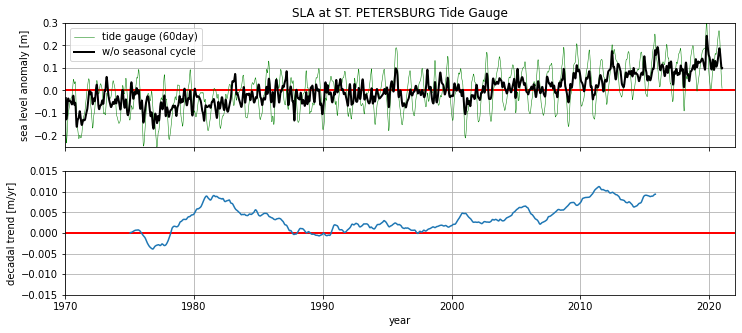

In [6]:
# ---- tide gauge over longer time and w/o seasonal cycle 
ids = data_da_l.location.data
stpete_xl_time = tg_xl.time.data
# - array of datetimes 
time_ord = np.nan*np.ones(len(stpete_xl_time))
for i in range(len(stpete_xl_time)):
    ts = (np.datetime64(str(stpete_xl_time[i])[0:10]) - np.datetime64('0000-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    time_ord[i] = ts/(60*60*24)
    
def seasonal_cycle(x,a,b,c,d,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + f 
def seasonal_plus_trend(x,a,b,c,d,e,f):
    return a*np.sin((2*np.pi/365)*x+b) + c*np.sin((2*np.pi/(365/2))*x+d) + e*x + f 

# extract station of interest 
st_i = 3 
stpete_xl = (tg_xl_a.sel(location=ids[st_i])).interpolate_na(dim='time',method='linear')
filt_len = 30 # smooth w/ boxcar filter length (days)
stpete_xl_3 = np.convolve((1/filt_len)*np.ones(filt_len),stpete_xl)
stpete_xl_3 = stpete_xl_3[np.int(filt_len/2):-np.int(filt_len/2)+1]

# -- fit seasonal cycle over entire time series 
fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], stpete_xl_3)
model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
stpete_xl_wo_season = xr.DataArray(data=stpete_xl_3 - model, dims=["time"],
                        coords=dict(time=(["time"], stpete_xl_time)))
# -- decadal trend in time 
dtl = 14900 # 11300 (time index when to stop trend fitting)
dec_tr = []; dec_tr_t = []
for i in range(0,dtl,14): # fit trend once a week 
    # -- OPTION 1: linear trend fit over time period of interest 
    this_slice = stpete_xl_wo_season[i:i+365*10] # fit trend over 10 year period
    # dt0 = this_slice.polyfit(dim='time', deg=1)
    # dec_tr.append((dt0.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365)
    # dec_tr_t.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
    # -- OPTION 2: seasonal cycle and trend fit at each time period 
    this_t = time_ord[i:i+365*10]
    fit = curve_fit(seasonal_plus_trend, this_t - this_t[0], stpete_xl_3[i:i+365*10])
    dec_tr.append(fit[0][4]*365) # linear trend
    dec_tr_t.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
    
f, (ax,ax2) = plt.subplots(2,1,figsize=(12,5))
ax.plot([data_da_xl.time[0].data, data_da_xl.time.time[-1].data], [0,0], color='r', linestyle='-', linewidth=2)   # zero line 
ax.plot(stpete_xl_time, stpete_xl_3, color='g',label='tide gauge (60day)',linewidth=0.5)  
# ax.plot(stpete_xl_time, model, color='r',linewidth=1,label='Tide Gauge')  
ax.plot(stpete_xl_time, stpete_xl_3 - model, color='k',linewidth=2,label='w/o seasonal cycle')  
# ax.plot(data_da_l.time, stpete_l, color='r',linewidth=1,label='Tide Gauge')  
ax.set_xlim([data_da_xl.time[0].data, data_da_xl.time.time[-1].data]); ax.set_xticklabels('')
ax.set_ylim([-0.25,0.3])
ax.legend(); ax.grid()
ax.set_ylabel('sea level anomaly [m]')
ax.set_title('SLA at ' + str(id_tags[st_i]) + ' Tide Gauge')

ax2.plot([data_da_xl.time[0].data, data_da_xl.time.time[-1].data], [0,0], color='r', linestyle='-', linewidth=2)   # zero line 
ax2.plot(dec_tr_t,dec_tr)
ax2.set_xlim([data_da_xl.time[0].data, data_da_xl.time.time[-1].data])
ax2.set_ylim([-0.015,0.015]); ax2.grid()
ax2.set_xlabel('year'); ax2.set_ylabel('decadal trend [m/yr]')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_09_01/tg_sla_trend_' + str(id_tags[st_i]) + '.jpg', dpi=350)

In [5]:
# consider each station of interest 
tcs = [0,1,2,3,5,6,8,13,15] 

# dtl = 14900 # 11300 (time index when to stop trend fitting)
dtl = 14900 # 11300 (time index when to stop trend fitting) 
# NEED TO STOP AT THIS INDEX BECAUSE IT IS THE START OF THE DECADE ENDING AT THE END OF THE RECORD ... 2021
t_int = 14

tg_trend_ts = np.nan*np.ones((len(tcs),len(range(0,dtl,t_int)))); count = 0
for st_i in tcs: 
    print(id_tags[st_i])
    stpete_xl = (tg_xl_a.sel(location=ids[st_i])).interpolate_na(dim='time',method='linear')
    filt_len = 30 # smooth w/ boxcar filter length (days)
    stpete_xl_3 = np.convolve((1/filt_len)*np.ones(filt_len),stpete_xl)
    stpete_xl_3 = stpete_xl_3[np.int(filt_len/2):-np.int(filt_len/2)+1]

    # -- fit seasonal cycle over entire time series 
    fit = curve_fit(seasonal_cycle, time_ord - time_ord[0], stpete_xl_3)
    model = seasonal_cycle((time_ord - time_ord[0]),*fit[0])
    stpete_xl_wo_season = xr.DataArray(data=stpete_xl_3 - model, dims=["time"],
                            coords=dict(time=(["time"], stpete_xl_time)))
    # -- decadal trend in time 
    dec_tr_m = []; dec_tr_t_m = []
    for i in range(0,dtl,t_int): # fit trend once a week 
        # -- OPTION 1: linear trend fit over time period of interest 
        this_slice = stpete_xl_wo_season[i:i+365*10] # fit trend over 10 year period
        # dt0 = this_slice.polyfit(dim='time', deg=1)
        # dec_tr.append((dt0.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365)
        # dec_tr_t.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
        # -- OPTION 2: seasonal cycle and trend fit at each time period 
        this_t = time_ord[i:i+365*10]
        fit = curve_fit(seasonal_plus_trend, this_t - this_t[0], stpete_xl_3[i:i+365*10])
        dec_tr_m.append(fit[0][4]*365) # linear trend
        dec_tr_t_m.append(this_slice.time[np.int(len(this_slice)/2)].data) # tag trend at time period mid-point
        
    if st_i < 1:
        time_master = dec_tr_t_m
    tg_trend_ts[count,:] = dec_tr_m
    count = count + 1

KEY WEST
NAPLES
FORT MYERS
ST. PETERSBURG
CEDAR KEY II
APALACHICOLA
PENSACOLA
GRAND ISLE
GALVESTON II PIER


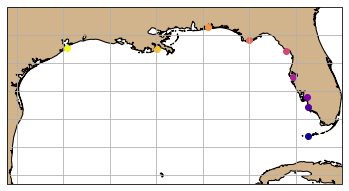

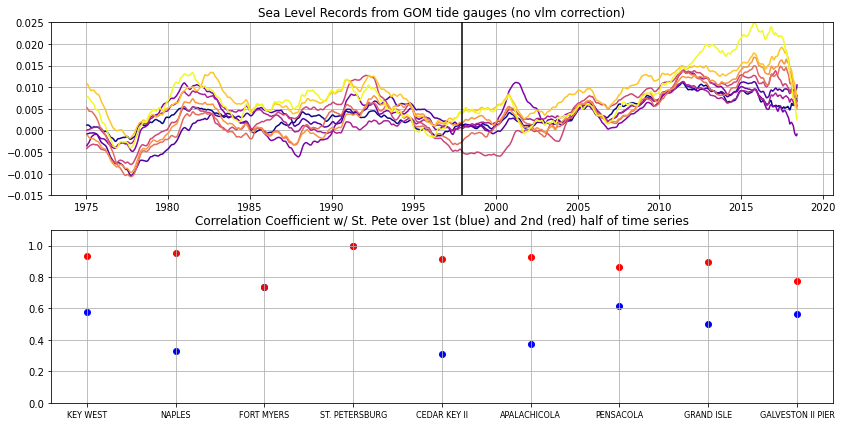

In [18]:
cc = plt.get_cmap('plasma',np.shape(tg_trend_ts)[0])
f, ax = plt.subplots(1,1,figsize=(6,4),subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tcs)):
    ax.scatter(data_da_xl.lon[tcs[i]].data,data_da_xl.lat[tcs[i]].data,color=cc(i),transform=ccrs.PlateCarree(),zorder=2)
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
gl.xlabels_bottom = False; gl.ylabels_left = False;
ax.set_xlim([-98,-80]); ax.set_ylim([22,31.5]);

t_i_split = np.int(len(time_master)/2)
f, (ax,ax1) = plt.subplots(2,1,figsize=(14,7))
for i in range(np.shape(tg_trend_ts)[0]):
    ax.plot(time_master,tg_trend_ts[i,:],color=cc(i))
ax.grid()
ax.plot([time_master[t_i_split],time_master[t_i_split]],[-0.015,0.025],color='k')
ax.set_ylim([-0.015,0.025])

tg_stp_cov_1 = np.nan*np.ones(len(tcs)); tg_stp_cov_2 = np.nan*np.ones(len(tcs)); xtl = []
for i in range(len(tcs)):
    covi = np.corrcoef(tg_trend_ts[i][0:t_i_split],tg_trend_ts[3][0:t_i_split])
    tg_stp_cov_1[i] = covi[0,1]
    covi = np.corrcoef(tg_trend_ts[i][t_i_split:],tg_trend_ts[3][t_i_split:])
    tg_stp_cov_2[i] = covi[0,1]
    ax1.scatter(i,tg_stp_cov_1[i],color='b')
    ax1.scatter(i,tg_stp_cov_2[i],color='r')
    xtl.append(id_tags[tcs[i]])

ax.set_title('Sea Level Records from GOM tide gauges (no vlm correction)')
ax1.set_title('Correlation Coefficient w/ St. Pete over 1st (blue) and 2nd (red) half of time series')
ax1.set_ylim([0,1.1])
ax1.set_xticks(np.arange(0,len(tcs)))
ax1.set_xticklabels(xtl,fontsize=8)
ax1.grid()

In [5]:
# -- ECCO GRIDS -- 
# base_dir = '/home/username/'
base_dir = '/Users/jakesteinberg/Documents/NASA_OSTST/ECCO/'
## define a high-level directory for ECCO fields
ECCO_dir = base_dir + '/v5'
## Load the model grid
grid_dir= ECCO_dir + '/nctiles_grid/'
# ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCOv4r3_grid.nc', k_subset=[0])
ecco_grid = ecco.load_ecco_grid_nc(grid_dir, 'ECCO-GRID.nc')

# bathymetry
tile_num=10
lon_range = [-98, -78]; lat_range = [17, 31] 
lons = ecco_grid.XC.sel(tile=tile_num)
lats = ecco_grid.YC.sel(tile=tile_num)
dep = ecco_grid.Depth
dep = dep.where(ecco_grid.hFacC.isel(tile=tile_num,k=0) !=0, np.nan).isel(tile=tile_num)

In [6]:
## ECCO SSH 
data_dir= ECCO_dir + '/nctiles_monthly'   
ecco_daily_vars = ecco.recursive_load_ecco_var_from_years_nc(data_dir, vars_to_load=['ETAN','PHIBOT'],\
                                           years_to_load=range(1993,2018)).load()    
## Merge the ecco_grid with the ecco_vars to make the ecco_ds
ecco_monthly_ds = xr.merge((ecco_grid , ecco_daily_vars))

loading files of  ETAN
loading files of  PHIBOT


In [7]:
# mask at the surface and total ocean area 
ocean_mask = np.ceil(ecco_monthly_ds.hFacC[0])
ocean_mask = ocean_mask.where(ocean_mask==1, np.nan)
total_ocean_area = np.sum(ecco_monthly_ds.rA*ocean_mask)
g = 9.81
rho0 = 1029

In [8]:
# -- OBP --  
obp_cor = 1029*(ecco_monthly_ds.PHIBOT + g*dep) # calculate OBP following ECCO code 
OBP_global_mean_mon = (obp_cor*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
obp_mgm = obp_cor - OBP_global_mean_mon      # subtract global spatial mean time series 
obp_anom = obp_mgm - obp_mgm.mean(dim='time')  # subtract time mean at each point 
t_s = '2010-01-01'
t_e = '2017-12-31'
obp_anom = obp_anom.sel(time=slice(t_s, t_e))
pobp = obp_anom.polyfit(dim='time', deg=1)
obp_a_trend = xr.polyval(obp_anom['time'], pobp.polyfit_coefficients) 

In [9]:
# -- ECCO SLA --  
ECCO_SSH_global_mean_mon = (ecco_monthly_ds.ETAN*ecco_monthly_ds.rA).sum(dim=['i','j','tile'])/total_ocean_area # global mean time series 
ECCO_ssh_mgm = ecco_monthly_ds.ETAN - ECCO_SSH_global_mean_mon       # subtract global spatial mean time series 
ECCO_ssh_anom = ECCO_ssh_mgm - ECCO_ssh_mgm.mean(dim='time')         # subtract time mean at each point  

In [9]:
# -- ECCO SLA -- trend (OLD NOT NEEDED when period of interest extends past ecco record)
# ecco_sub1 = ECCO_ssh_anom.sel(time=slice('2008-01-15', '2017-12-15'))
# p1_ec = ecco_sub1.polyfit(dim='time', deg=1)
# p1_ec_r = (p1_ec.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
# ecco_trend_star = xr.polyval(ecco_sub1['time'], p1_ec.polyfit_coefficients)

In [10]:
# -- Vertical Land Motion -- from multiple stations interpolated to tide gauge sites (better data)
file_int = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vlm_at_psmsl_gauges.txt")
data_int = file_int.readlines()
file_int.close()
name = []
name_row = []
for i in range(len(data_int)):
    if data_int[i][0] == '>':
        for j in range(len(data_int[i])):
            if data_int[i][j] == '\n':
                ee = j
                break
        name.append(data_int[i][9:ee])
        name_row.append(i)
        
# -- processing to get one number per tide gauge site 
id_tags = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE STATE DOCKS, ALABAMA', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON II, PIER 21, TX', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']
vlm_rate = np.nan*np.ones(len(id_tags))
vlm_un = np.nan*np.ones(len(id_tags))
for i in range(len(id_tags)):
    ii = name.index(id_tags[i])
    this_row = data_int[name_row[ii]+1].split()
    vlm_rate[i] = -1*np.float64(this_row[3])/1000  # convert from mm/yr
    vlm_un[i] = np.float64(this_row[4])/1000 # uncertainty 

In [14]:
# DONT USE 
# # -- Vertical Land Motion -- secondary choice, nearest neighbor estimate (OLDER) (dont use)
# file = open("/Users/jakesteinberg/Documents/NASA_OSTST/tide_gauge/vertical_velocities_table_updated.txt")
# # data = file.readlines()
# data = np.loadtxt(file,skiprows=13,usecols=(2,3,4,5,6,7))
# file.close()
# # -- find closest distance from gauges of interest -- 
# closest = np.nan*np.ones(len(data_da.lon)); dist_b = np.nan*np.ones(len(data_da.lon)); rate = np.nan*np.ones(len(data_da.lon));
# for i in range(len(data_da.lon)):
#     sta_lon = data_da.lon[i].data
#     sta_lat = data_da.lat[i].data
#     dist_x = 1852*60*np.cos(np.deg2rad(sta_lat))*(data[:,0] - sta_lon)
#     dist_y = 1852*60*(data[:,1] - sta_lat)
#     dist = np.sqrt(dist_x**2 + dist_y**2)
#     closest[i] = int(np.where(dist == np.nanmin(dist))[0][0])
#     dist_b[i] = dist[int(np.where(dist == np.nanmin(dist))[0][0])]
#     rate[i] = -1*data[int(np.where(dist == np.nanmin(dist))[0][0]),4]/1000

In [11]:
# -- compare values 
tg_obp_trend_a = p1_test # p1_test is for the 2010-2019 decade 
print('### tide gauge trend ### ')
print(np.round(tg_obp_trend_a.data,3))
# print('percent of tide gauge trend from VLM')
# print(100*(rate/tg_obp_trend_a.data))
print('### percent of tide gauge trend from VLM sta. interp ###')
print(np.round(100*(vlm_rate/tg_obp_trend_a.data),1))
tg_obp_trend_a = p1_test.data
tg_obp_trend_a_mvlm = p1_test.data - vlm_rate
print('### tide gauge trend w/ VLM adjustment ###')
print(np.round(tg_obp_trend_a_mvlm,3))

### tide gauge trend ### 
[0.011 0.013 0.01  0.01  0.014 0.014 0.014 0.014 0.017 0.017 0.013 0.016
 0.016 0.017 0.024 0.023 0.018 0.018 0.016]
### percent of tide gauge trend from VLM sta. interp ###
[13.3 11.3 14.9 14.4 11.   4.1  7.6 12.5 13.5 12.9 15.8  6.3  7.7 40.5
 11.5 14.3 17.7 10.  11.2]
### tide gauge trend w/ VLM adjustment ###
[0.01  0.012 0.008 0.009 0.012 0.014 0.013 0.012 0.014 0.015 0.011 0.015
 0.015 0.01  0.021 0.02  0.015 0.016 0.014]


In [12]:
# -- MERGE large AVISO datasets for a zoomed out view 
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1993_1998.nc'
av1 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_1999_2004.nc'
av2 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2005_2010.nc'
av3 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2011_2016.nc'
av4 = xr.open_dataset(av_path)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_natl_obs-sl_glo_phy-ssh_my_allsat-l4-duacs-0.25deg_P1D_2017_2021.nc'
av5 = xr.open_dataset(av_path)
av_tot = xr.concat([av1,av2,av3,av4,av5], dim='time')

In [13]:
# AVISO SLA 
avsla_raw = av_tot.sla
# --- remove spatial mean from each time 
# avsla_raw = avsla_raw - msl
# --- remove time mean (if generating master time series plot )
avsla_raw_mean = avsla_raw.sel(time=slice("1993-01-01", "2021-08-02")).mean(dim='time')
avsla_raw = avsla_raw - avsla_raw_mean
# --- extract times over 3 decades and full record
avsla_trend_time_1 = av_tot.time.sel(time=slice("1993-01-01", "2002-12-31"))   # oldest ten
avsla_trend_time_2 = av_tot.time.sel(time=slice("2008-01-01", "2017-12-31"))   # ecco ten
avsla_trend_time_3 = av_tot.time.sel(time=slice("2010-06-30", "2020-06-30"))   # ten of interest 
avsla_trend_time_tot = av_tot.time.sel(time=slice("1993-01-01", "2021-08-02")) # total
# --- extract sla over desired times 
# first decade 
avsla_raw_1 = avsla_raw.sel(time=slice("1993-01-01", "2002-12-31"))
# second decade (special decade)
avsla_raw_2 = avsla_raw.sel(time=slice("2008-01-01", "2017-12-31"))
avsla_raw_2_mean = avsla_raw_2.mean(dim='time')
avsla_raw_2_a = avsla_raw_2 - avsla_raw_2_mean
# - third decade 
avsla_raw_3 = avsla_raw.sel(time=slice("2010-06-30", "2020-06-30"))
#- full record 
avsla_raw_tot = avsla_raw.sel(time=slice("1993-01-01", "2021-08-02"))
avsla_raw_tot_mean = avsla_raw_tot.mean(dim='time')
avsla_raw_tot_a = avsla_raw_tot - avsla_raw_tot_mean
# --- fit linear trends to each 
pavsla_1 = avsla_raw_1.polyfit(dim='time', deg=1)
pavsla_2 = avsla_raw_2_a.polyfit(dim='time', deg=1) # fitting the anomaly here! 
pavsla_3 = avsla_raw_3.polyfit(dim='time', deg=1) 
pavsla_tot = avsla_raw_tot.polyfit(dim='time', deg=1)
aviso_1_sla_trend = pavsla_1.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
aviso_2_sla_trend = pavsla_2.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
aviso_3_sla_trend = pavsla_3.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
aviso_tot_sla_trend = pavsla_tot.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365

avsla_trend_1 = xr.polyval(avsla_raw_1['time'], pavsla_1.polyfit_coefficients)
avsla_trend_2 = xr.polyval(avsla_raw_2['time'], pavsla_2.polyfit_coefficients)
avsla_trend_3 = xr.polyval(avsla_raw_3['time'], pavsla_3.polyfit_coefficients)

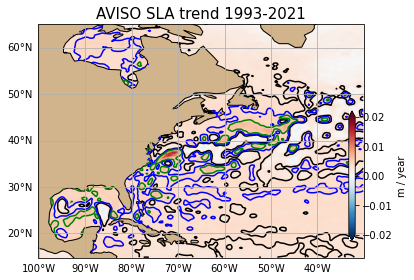

In [32]:
clim = [-0.02, 0.02]; colMap = plt.get_cmap('RdBu_r');
f, ax1 = plt.subplots(1,1,figsize=(6,4), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Kc = aviso_tot_sla_trend.plot(ax=ax1,transform=ccrs.PlateCarree(), add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
aviso_tot_sla_trend.plot.contour(ax=ax1,transform=ccrs.PlateCarree(), levels=[0.003], colors='k')
aviso_tot_sla_trend.plot.contour(ax=ax1,transform=ccrs.PlateCarree(), levels=[0.004], colors='b')
aviso_tot_sla_trend.plot.contour(ax=ax1,transform=ccrs.PlateCarree(), levels=[0.005], colors='g')
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines()
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax1.set_title('AVISO SLA trend 1993-2021',fontsize=15)
cbpos = [0.86, 0.15, 0.015, 0.45]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m / year'); plt.tight_layout(); 
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_aviso_trend_natl_full.jpg', dpi=350)

In [14]:
# find aviso index to TG site selected above [lon_site = -83; lat_site = 28] 
ids = data_da_l.location.data
lon_site = data_da_l.lon[3].data # index 3 = st. pete 
lat_site = data_da_l.lat[3].data
avloni = np.where((av_tot.longitude > lon_site-.15) & (av_tot.longitude < lon_site+.15))[0][0]
avlati = np.where((av_tot.latitude > lat_site-.15) & (av_tot.latitude < lat_site+.15))[0][0]

In [15]:
# smooth aviso to monthly time scale at tide gauge site 
av_ts_at_site0 = avsla_raw_tot_a[:, avlati, avloni]
# av_ts_at_sitet = savgol_filter(av_ts_at_site0,31,polyorder=3)
filt_len = 30 # boxcar filter 
av_ts_at_site1 = np.convolve((1/30)*np.ones(30),av_ts_at_site0)
av_ts_at_site = av_ts_at_site1[np.int(filt_len/2):-np.int(filt_len/2)+1]

In [17]:
# find decade with largest positive trend (at site)
av_trend_i = np.nan*np.ones(20)
for i in range(20):
    ts = 1993 + i + 0
    te = ts + 9
    # print(str(ts)+'-'+str(te))
    avsla_sub = av_ts_at_site0.sel(time=slice(str(ts)+"-01-01", str(te)+"-12-31")) 
    fit_i = avsla_sub.polyfit(dim='time', deg=1)
    av_trend_i[i] = fit_i.polyfit_coefficients[0]
print(str(1993 + np.where(av_trend_i == np.nanmax(av_trend_i))[0]) + '-' + \
      str(1993 + np.where(av_trend_i == np.nanmax(av_trend_i))[0] + 9))
# 2010-2019 = very close second for max rate at st. pete 
av_trend_i

[2007]-[2016]


array([8.17251777e-20, 8.63345094e-20, 7.63611379e-20, 1.15165071e-19,
       5.46205145e-20, 3.47536488e-20, 4.14106110e-20, 1.35548759e-19,
       1.66102668e-19, 1.21728261e-19, 1.93269202e-19, 2.35124320e-19,
       2.92448767e-19, 3.58003731e-19, 3.98950028e-19, 3.90440732e-19,
       3.30186259e-19, 3.94955305e-19, 3.21941151e-19, 2.11571758e-19])

In [16]:
# --- AVISO fit to anomaly (defined relative to total time mean over subset time) (special decade different than that above)
# avsla_time_star = av_tot.time.sel(time=slice("2010-01-01", "2019-12-31"))
# avsla_raw_tot_a_sub = avsla_raw_tot_a.sel(time=slice("2010-01-01", "2019-12-31"))[:, avlati, avloni] 
# pavsla_star = avsla_raw_tot_a_sub.polyfit(dim='time', deg=1)   
# avsla_trend_star = xr.polyval(avsla_raw_tot_a_sub['time'], pavsla_star.polyfit_coefficients)
# ---TIDE GAUGE trend, fit trend over same decade to compare w/aviso 
tg_sub2_l_a = tg_sub_l_a.sel(time=slice('2010-06-30', '2020-06-30'))
p2_test = tg_sub2_l_a.polyfit(dim='time', deg=1)
p2_2_test = (p2_test.isel(degree=0).polyfit_coefficients)*1e9*60*60*24*365
this_trend = xr.polyval(tg_sub2_l_a.time, p2_test.polyfit_coefficients[:,3])

In [17]:
print(pavsla_3.polyfit_coefficients.data[:, avlati, avloni] )
print(p2_test.polyfit_coefficients[:,3].data)

[ 2.81621788e-19 -3.58195099e-01]
[ 2.41682135e-19 -2.98172763e-01]


In [18]:
# find ECCO index to site selected above
this_ecco = ECCO_ssh_anom.isel(tile=10)
ecco_i = np.where((this_ecco.XC > lon_site-.15) & (this_ecco.XC < lon_site+.15) & \
                  (this_ecco.YC > lat_site-.15) & (this_ecco.YC < lat_site+.15))

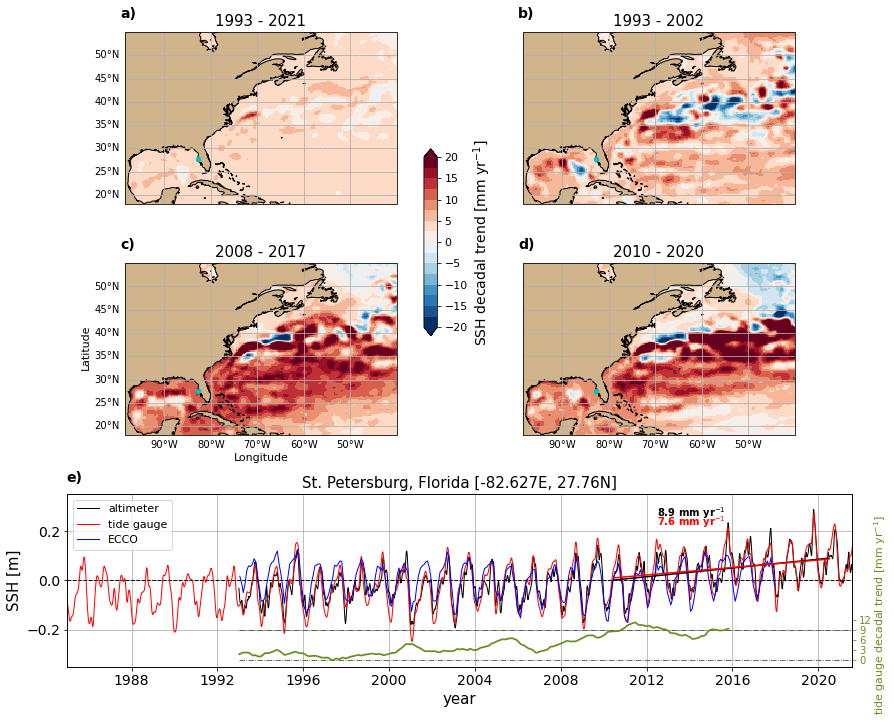

In [22]:
clim = [-0.02, 0.02]; colMap = plt.get_cmap('RdBu_r',16); ax_x = [-98.5,-40]; ax_y = [18,55]; 
fig = plt.figure(tight_layout=True,figsize=(12.5,10)); gs = gridspec.GridSpec(3, 2)
ax0 = fig.add_subplot(gs[0, 0],projection = ccrs.PlateCarree(central_longitude=0))
ax1 = fig.add_subplot(gs[0, 1],projection = ccrs.PlateCarree(central_longitude=0))
ax2 = fig.add_subplot(gs[1, 0],projection = ccrs.PlateCarree(central_longitude=0))
ax3 = fig.add_subplot(gs[1, 1],projection = ccrs.PlateCarree(central_longitude=0))
ax4 = fig.add_subplot(gs[2,:])
# --- FULL RECORD --- 
Kc = aviso_tot_sla_trend.plot(ax=ax0,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
ax0.scatter(av_tot.longitude[avloni]-0.2,av_tot.latitude[avlati],s=20,color='c',transform=ccrs.PlateCarree(),zorder=2)
ax0.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax0.coastlines()
gl = ax0.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.xlabels_bottom = False;
ax0.set_xlim(ax_x); ax0.set_ylim(ax_y);
ax0.set_title(str(avsla_trend_time_tot[0].data)[0:4] + ' - ' + \
              str(avsla_trend_time_tot[-1].data)[0:4],fontsize=15)
# --- DECADE 1 --- 
Kc = aviso_1_sla_trend.plot(ax=ax1,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
ax1.scatter(av_tot.longitude[avloni]-0.2,av_tot.latitude[avlati],s=20,color='c',transform=ccrs.PlateCarree(),zorder=2)
ax1.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax1.coastlines()
gl = ax1.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False; gl.xlabels_bottom = False;
ax1.set_xlim(ax_x); ax1.set_ylim(ax_y);
ax1.set_title(str(avsla_trend_time_1[0].data)[0:4] + ' - ' + \
              str(avsla_trend_time_1[-1].data)[0:4],fontsize=15)
# --- DECADE 2 --- 
Kc = aviso_2_sla_trend.plot(ax=ax2,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0],vmax=clim[-1],cmap=colMap)
ax2.scatter(av_tot.longitude[avloni]-0.2,av_tot.latitude[avlati],s=20,color='c',transform=ccrs.PlateCarree(),zorder=2)
ax2.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax2.coastlines()
gl = ax2.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax2.set_xlim(ax_x); ax2.set_ylim(ax_y);
ax2.set_title(str(avsla_trend_time_2[0].data)[0:4] + ' - ' + \
              str(avsla_trend_time_2[-1].data)[0:4],fontsize=15)
# --- DECADE 3
Kc = (aviso_3_sla_trend*np.array([1000])).plot(ax=ax3,transform=ccrs.PlateCarree(),add_colorbar=False,vmin=clim[0]*1000,vmax=clim[-1]*1000,cmap=colMap)
ax3.scatter(av_tot.longitude[avloni]-0.2,av_tot.latitude[avlati],s=20,color='c',transform=ccrs.PlateCarree(),zorder=2)
ax3.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax3.coastlines()
gl = ax3.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False; gl.ylabels_left = False;
ax3.set_xlim(ax_x); ax3.set_ylim(ax_y);
ax3.set_title(str(avsla_trend_time_3[0].data)[0:4] + ' - ' + \
              str(avsla_trend_time_3[-1].data)[0:4],fontsize=15)
# -- SUBPLOT time series --
ax4.plot([data_da_xl.time[5479].data, av_tot.time[-1].data], [0,0], color='k', linestyle='--', linewidth=1)     # zero line 
ax4.plot(av_tot.time, av_ts_at_site, label='altimeter',linewidth=1, color='k');                                     # aviso filtered to monthly time scale 
tg_smooth = np.convolve((1/30)*np.ones(30),data_da_xl.sel(location=ids[3]) - np.nanmean(data_da_l.sel(location=ids[3])))
tg_smooth = tg_smooth[np.int(filt_len/2):-np.int(filt_len/2)+1]
ax4.plot(data_da_xl.time, tg_smooth, color='r',linewidth=1,label='tide gauge')                                  # tide gauge over full record (anomaly relative to _l mean and 30 day filter)
# ax4.plot(data_da_l.time,data_da_l.sel(location=ids[3])-np.nanmean(data_da_l.sel(location=ids[3])),color='r',linewidth=1,label='Tide Gauge')                                                        # #FF4500 # tide gauge
ax4.plot(this_ecco.time, this_ecco[:,ecco_i[0][0]-2,ecco_i[1][0]+1].squeeze(), color='b', label='ECCO', linewidth=1)  # #487E30 ecco 
# - select decade trend -- 
ax4.plot(avsla_trend_time_3, avsla_trend_3[:, avlati, avloni], color='k',linewidth=1.5); # '#2B00B8'
ax4.plot(tg_sub2_l_a.time,this_trend,color='r',linewidth=1.5) # '#E28839'
ax4.text(av_tot.time[7108].data, 0.26, \
         str(np.round(pavsla_3.polyfit_coefficients[0,avlati, avloni].data*1e9*60*60*24*365*1000,1))+ ' mm yr$^{-1}$',color='k',fontweight='bold',fontsize=10)
ax4.text(av_tot.time[7108].data, 0.26-0.04, \
         str(np.round(p2_test.polyfit_coefficients[0,3].data*1e9*60*60*24*365*1000,1)) + ' mm yr$^{-1}$',color='r',fontweight='bold',fontsize=10)

ax4.legend(fontsize=11,loc=0); ax4.set_ylim([-0.35,0.35]); ax4.set_xlabel('year', fontsize=15); ax4.set_ylabel('SSH [m]', fontsize=15); ax4.grid()
ax4.set_title('St. Petersburg, Florida [' + str(np.round(lon_site,3)) + 'E, ' + str(np.round(lat_site,3)) + 'N]',fontsize=15)
ax4.set_xlim([data_da_xl.time[5479], av_tot.time[-1].data]); # ax4.set_xlim([av_tot.time[0].data, av_tot.time[-1].data]);
ax4.tick_params(axis='x', labelsize=14)
ax4.tick_params(axis='y', labelsize=14)

# TREND w/o season 
ax5=ax4.twinx() # decadal trend in time 
sgc = '#415a32' # '#6B8E23'
ax5.plot([dec_tr_t[469],av_tot.time[-1].data],1000*np.array([0,0]),color=sgc,linestyle='-.',linewidth=0.85) # index 469 is start of 1993 
ax5.plot([dec_tr_t[469],av_tot.time[-1].data],1000*np.array([0.009,0.009]),color=sgc,linestyle='-.',linewidth=0.85,zorder=1) # index 469 is start of 1993 
ax5.plot(dec_tr_t[469:],np.array([1000])*dec_tr[469:],color='#6B8E23',linewidth=1.75,zorder=2)
ax5.set_ylim(np.array([1000])*[-0.002, 0.05]); ax5.set_yticks(np.array([1000])*[0, 0.003, 0.006, 0.009, 0.012])
ax5.tick_params(axis='y', colors='#6B8E23'); ax5.set_ylabel('tide gauge decadal trend [mm yr$^{-1}$]',color='#6B8E23',fontsize=11); ax5.yaxis.set_label_coords(1.025,0.3)
ax5.set_xlim([data_da_xl.time[5479], av_tot.time[-1].data]); 

cbpos = [0.475, 0.53, 0.015, 0.26]; cax = fig.add_axes(cbpos); 
cb = plt.colorbar(Kc, cax=cax, orientation='vertical', extend='both'); 
cb.ax.tick_params(labelsize=11)
cb.ax.set_ylabel('SSH decadal trend [mm yr$^{-1}$]',fontsize=14)
ax0.text(ax_x[0]-1,ax_y[1]+3,'a)',fontsize=14,fontweight='bold'); ax1.text(ax_x[0]-1,ax_y[1]+3,'b)',fontsize=14,fontweight='bold')
ax2.text(ax_x[0]-1,ax_y[1]+3,'c)',fontsize=14,fontweight='bold'); ax3.text(ax_x[0]-1,ax_y[1]+3,'d)',fontsize=14,fontweight='bold')
ax4.text(np.datetime64('1984-12-10'),0.4,'e)',fontsize=14,fontweight='bold')
ax2.text(-75,12.5,'Longitude',fontsize=11)
ax2.text(-108,32.5,'Latitude',fontsize=11,rotation=90)
plt.show()
fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures_v2/aviso_tg_trends.jpg', dpi=350)
# fig.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_09_01/aviso_tg_trends.jpg', dpi=300)

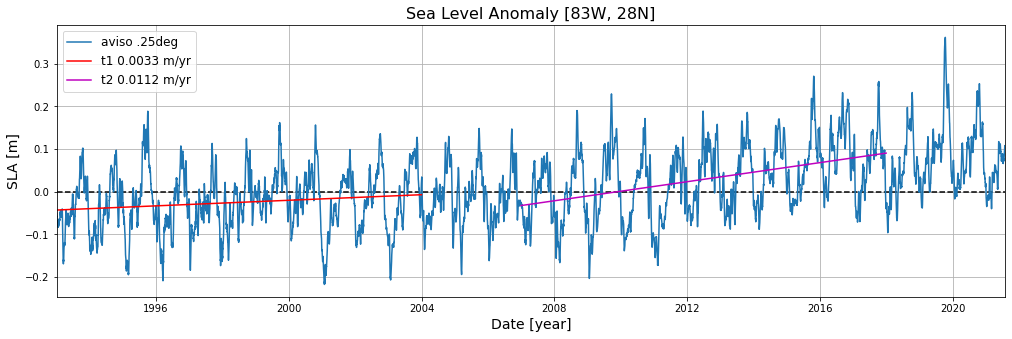

In [15]:
# find aviso index to site selected above
lon_site = -83; lat_site = 28; 
avloni = np.where((av_tot.longitude > lon_site-.15) & (av_tot.longitude < lon_site+.15))[0][0]
avlati = np.where((av_tot.latitude > lat_site-.15) & (av_tot.latitude < lat_site+.15))[0][0]

# -- aviso 
f, (ax) = plt.subplots(1,1,figsize=(15,4))
ax.plot([av_tot.time[0].data, av_tot.time[-1].data], [0,0], color='k', linestyle='--')
ax.plot(av_tot.time, avsla_raw[:, avlati, avloni], label='aviso .25deg',linewidth=1.5); 

# -- aviso trends 
ax.plot(avsla_trend_time_1, avsla_trend_1[:, avlati, avloni], \
        label='t1 ' + str(np.round(pavsla_1.polyfit_coefficients[0, avlati, avloni].data*1e9*60*60*24*365,4)) + ' m/yr', color='r'); 
ax.plot(avsla_trend_time_2, avsla_trend_2[:, avlati, avloni], \
        label='t2 ' + str(np.round(pavsla_2.polyfit_coefficients[0, avlati, avloni].data*1e9*60*60*24*365,4)) + ' m/yr', color='m'); 

ax.grid(); ax.set_xlabel('Date [year]',fontsize=14); ax.set_ylabel('SLA [m]',fontsize=14)
ax.set_title('Sea Level Anomaly ['+str(-1*lon_site) + 'W, ' + str(lat_site) + 'N]', fontsize=16)
ax.set_xlim([av_tot.time[0].data, av_tot.time[-1].data]); ax.legend(fontsize=12)
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_aviso_time_series.jpg', dpi=250)

In [115]:
# grid and find AVISO trend nearest to tide gauge 
av_lon, av_lat = np.meshgrid(av_tot.longitude.data, av_tot.latitude.data)
aviso_sla_trend_f = aviso_2_sla_trend.data.flatten() # aviso_2_sla_trend
nb_trend = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    dist_x = 1852*60*np.cos(np.deg2rad(sta_lat))*(av_lon.flatten() - sta_lon)
    dist_y = 1852*60*(av_lat.flatten() - sta_lat)
    dist = np.sqrt(dist_x**2 + dist_y**2)
    nearby_i = np.where(dist <= 35000)
    nb_trend[i] = np.nanmean(aviso_sla_trend_f[nearby_i])

In [117]:
# do better than cell above 
avsla_raw_tot_a_sub_ar = avsla_raw_tot_a.sel(time=slice("2010-01-01", "2019-12-31"))
pavsla_star_ar = avsla_raw_tot_a_sub_ar.polyfit(dim='time', deg=1)  
# find AVISO nearest to tide gauge
nb_trend = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    avlonii = np.where((av_tot.longitude > sta_lon-.15) & (av_tot.longitude < sta_lon+.15))[0][0]
    avlatii = np.where((av_tot.latitude > sta_lat-.15) & (av_tot.latitude < sta_lat+.15))[0][0]
    nb_trend[i] = np.round(pavsla_star_ar.polyfit_coefficients[0, avlatii, avlonii].data*1e9*60*60*24*365,5)

In [120]:
# -- find AVISO time series nearest to tide gauge 
# avtgsla = np.nan*np.ones((len(data_da.lon), len(avsla_raw_2.time)))
# avtgsla_fit = np.nan*np.ones((len(data_da.lon), len(avsla_raw_2.time)))
# for i in range(len(data_da.lon)):
#     sta_lon = data_da.lon[i].data
#     sta_lat = data_da.lat[i].data
#     avloni = np.where((av.longitude.data < (sta_lon+0.35)) & (av.longitude.data > (sta_lon-0.35)))[0]
#     avlati = np.where((av.latitude.data < (sta_lat+0.35)) & (av.latitude.data > (sta_lat-0.35)))[0]
#     avtgsla[i,:] = np.nanmean(np.nanmean(avsla_raw_2_a[:,avlati,avloni],axis=1),axis=1) 
#     avtgsla_fit[i,:] = np.nanmean(np.nanmean(avsla_trend_2[:,avlati,avloni],axis=1),axis=1) 

In [134]:
# find ECCO OBP trend nearest to tide gauge 
ectgobp = np.nan*np.ones(len(data_da.lon))
for i in range(len(data_da.lon)):
    sta_lon = data_da.lon[i].data
    sta_lat = data_da.lat[i].data
    ecli = np.where((lons > sta_lon-.25) & (lons < sta_lon+.25) & (lats > sta_lat-.25) & (lats < sta_lat+.25))
    ectgobp[i] = np.nanmean(pobp.isel(tile=10,degree=0).polyfit_coefficients[ecli[0], ecli[1]]*1e9*60*60*24*365/g/rho0)

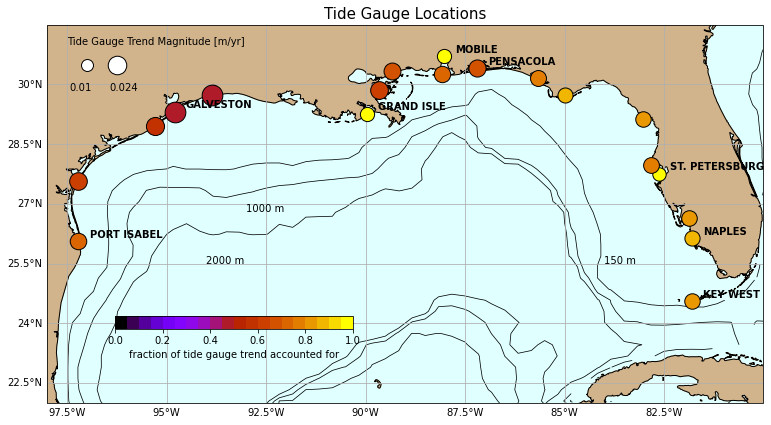

In [188]:
# Locations 
argo = 0.00742
argo_grace = argo + 0.00355
cmap = mpl.cm.get_cmap('gnuplot',20)
clow = 0
chigh = 1
norm = mpl.colors.Normalize(vmin=clow, vmax=chigh)

id_tags_short = ['KEY WEST','NAPLES','FORT MYERS','ST. PETERSBURG','CLEARWATER BEACH', 'CEDAR KEY II', 'APALACHICOLA', 'PANAMA CITY, ST.ANDREWS BAY, FL', 'PENSACOLA', \
          'DAUPHIN ISLAND', 'MOBILE', 'BAY WAVELAND YACHT CLUB' ,'SHELL BEACH, LOUISIANA', 'GRAND ISLE', 'SABINE PASS', 'GALVESTON', \
          'FREEPORT', 'CORPUS CHRISTI, GULF MEXICO, TX', 'PORT ISABEL']

f, ax = plt.subplots(1,1,figsize=(11,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
for i in range(len(tg_data['lat'][0,:])):
    # ax.scatter(data[np.int(closest[i]),0],data[np.int(closest[i]),1],color='#7CFC00',s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k',marker='x')
    s_i = 250*(tg_obp_trend_a[i] - vlm_rate[i])/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate))
    ax.scatter(tg_data['lon'][0,i],tg_data['lat'][0,i], \
               color=cmap(argo_grace/(tg_obp_trend_a[i] - vlm_rate[i])),\
               s=s_i,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- TG trend minus VLM
    # ax.scatter(tg_data['lon'][0,i],tg_data['lat'][0,i],\
    #           color=[cmap( ((tg_obp_trend_a_mvlm[i]-0.003) - clow)/(chigh - clow) )],s=120,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- TG trend
    # ax.scatter(tg_data['lon'][0,i]+0.35,tg_data['lat'][0,i],\
    #            color=[cmap( (tg_obp_trend_a[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- aviso
    # ax.scatter(tg_data['lon'][0,i]-0.35,tg_data['lat'][0,i],\
    #            color=[cmap( (nb_trend[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
    # -- ecco OBP 
    # ax.scatter(tg_data['lon'][0,i]-0.7,tg_data['lat'][0,i],\
    #            color=[cmap( (ectgobp[i] - clow)/(chigh - clow) )],s=75,transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')    

ax.scatter(-97,30.5,200*np.nanmin(tg_obp_trend_a - vlm_rate)/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate)),\
           color='w',transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.text(-97.45,29.85,str(np.round(np.nanmin(tg_obp_trend_a - vlm_rate),3)))
ax.scatter(-96.25,30.5,200*np.nanmax(tg_obp_trend_a - vlm_rate)/(np.nanmax(tg_obp_trend_a - vlm_rate) - np.nanmin(tg_obp_trend_a - vlm_rate)),\
           color='w',transform=ccrs.PlateCarree(),zorder=3,edgecolor='k')
ax.text(-96.45,29.85,str(np.round(np.nanmax(tg_obp_trend_a - vlm_rate),3)))
ax.text(-97.5,31,'Tide Gauge Trend Magnitude [m/yr]')
    
i0 = 1
i1 = 3
i2 = 10
i3 = 13
i4 = 18
ii = [0,1,3,8,10,13,15,18]
for i in ii:
    ax.text(tg_data['lon'][0,i]+0.28,tg_data['lat'][0,i]+0.1,id_tags_short[i],fontsize=10,fontweight='bold')
# ax.text(tg_data['lon'][0,i1]+0.3,tg_data['lat'][0,i1],id_tags[i1],fontsize=10,fontweight='bold')
# ax.text(tg_data['lon'][0,i2]+0.3,tg_data['lat'][0,i2]+0,id_tags[i2],fontsize=10,fontweight='bold')
# ax.text(tg_data['lon'][0,i3]-0.3,tg_data['lat'][0,i3]-0.5,id_tags[i3],fontsize=10,fontweight='bold')
# ax.text(tg_data['lon'][0,i4]+0.2,tg_data['lat'][0,i4]-0,id_tags[i4],fontsize=10,fontweight='bold')

# ax.scatter(-82,30.5,color=[cmap( (0.006 - clow)/(chigh - clow) )],s=150,transform=ccrs.PlateCarree(),zorder=3)
# ax.text(-83.25,30,'Argo Profile = 0.006', fontweight='bold')
ax.contour(lons,lats,dep,levels=[150],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-84,25.5,'150 m', color='k')
ax.contour(lons,lats,dep,levels=[1000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-93,26.8,'1000 m', color='k')
ax.contour(lons,lats,dep,levels=[2000],colors='k',transform=ccrs.PlateCarree(),linewidths=0.75)
ax.text(-94,25.5,'2000 m', color='k')
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_xlim([-98,-80]); ax.set_ylim([22,31.5]);
ax.set_title('Tide Gauge Locations',fontsize=15) 

ax.set_facecolor('#E0FFFF');
cbpos = [0.15, 0.23, 0.3, 0.03]; cax = f.add_axes(cbpos); 
f.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),
             cax=cax, orientation='horizontal', label='fraction of tide gauge trend accounted for')
plt.tight_layout()
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/wip_tide_gauge_loc.jpg', dpi=250)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_07/tide_gauge_stations.jpg', dpi=250)

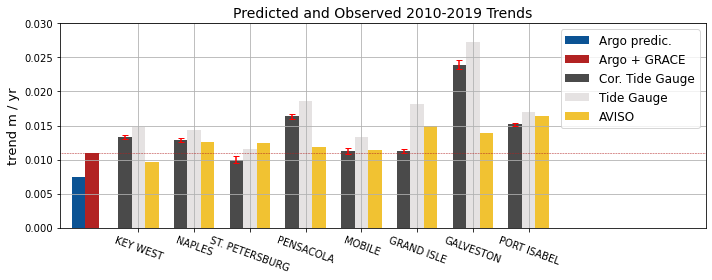

In [182]:
f, ax = plt.subplots(1,1,figsize=(10,4),tight_layout=True)
ax.grid()
# ax.bar(0.4,ectgobp[i] - 0.0030186245502099134,width=0.2,label='ECCO OBP$_a$')
wid = 0.145
argo = 0.00742 # 0.00816, 0.00636 

ax.bar(0.5,argo, width=wid,label='Argo predic.',color='#0b5394')
ax.bar(0.5+wid,argo + 0.002 + 0.00155 ,width=wid,label='Argo + GRACE',color='#B22222')

wid = 0.145
ii = [0,1,3,8,10,13,15,18]
ipos = np.array([1,1.6,2.2,2.8,3.4,4,4.6,5.2])
for i in range(len(ii)):
    if i < 1:
        ax.bar(i+1,tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],width=wid,label='Cor. Tide Gauge',color='#4a4a4a')
        ax.errorbar(i+1,tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],yerr=vlm_un[ii[i]],capsize=3, color='r')
        ax.bar(i+1+wid,tg_obp_trend_a[ii[i]],width=wid,label='Tide Gauge', color='#e5e2e2')
        ax.bar(i+1+2*wid,nb_trend[ii[i]],width=wid, label='AVISO', color='#f1c232')
    else:
        ax.bar((ipos[i]),tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],width=wid,color='#4a4a4a')
        ax.errorbar((ipos[i]),tg_obp_trend_a[ii[i]] - vlm_rate[ii[i]],yerr=vlm_un[ii[i]],capsize=3,color='r')
        ax.bar((ipos[i]) + wid,tg_obp_trend_a[ii[i]],width=wid,color='#e5e2e2')
        ax.bar((ipos[i]) + 2*wid,nb_trend[ii[i]],width=wid,color='#f1c232')

ax.plot([0,8],[argo_grace,argo_grace],color='#B22222',linestyle='--',linewidth=0.5)
# i1 = 1
# ax.bar(1,tg_obp_trend_a[i1] - vlm_rate[i1],width=wid,label='Cor. Tide Gauge',color='k')
# ax.errorbar(1,tg_obp_trend_a[i1] - vlm_rate[i1],yerr=vlm_un[i1],capsize=3, color='r')
# ax.bar(1+wid,tg_obp_trend_a[i1],width=wid,label='Tide Gauge', color='#D3D3D3')
# ax.bar(1+2*wid,nb_trend[i1],width=wid, label='AVISO', color='#FA8072')

# i2 = 10
# ax.bar(2,tg_obp_trend_a[i2] - vlm_rate[i2],width=wid,color='k')
# ax.errorbar(2,tg_obp_trend_a[i2] - vlm_rate[i2],yerr=vlm_un[i2],capsize=3, color='r')
# ax.bar(2+wid,tg_obp_trend_a[i2],width=wid, color='#D3D3D3')
# ax.bar(2+2*wid,nb_trend[i2],width=wid, color='#FA8072')

# i3 = 13
# ax.bar(3,tg_obp_trend_a[i3] - vlm_rate[i3],width=wid,color='k')
# ax.errorbar(3,tg_obp_trend_a[i3] - vlm_rate[i3],yerr=vlm_un[i3],capsize=3, color='r')
# ax.bar(3+wid,tg_obp_trend_a[i3],width=wid, color='#D3D3D3')
# ax.bar(3+2*wid,nb_trend[i3],width=wid, color='#FA8072')

# i4 = 18
# ax.bar(4,tg_obp_trend_a[i4] - vlm_rate[i4],width=wid,color='k')
# ax.errorbar(4,tg_obp_trend_a[i4] - vlm_rate[i4],yerr=vlm_un[i4],capsize=3, color='r')
# ax.bar(4+wid,tg_obp_trend_a[i4],width=wid, color='#D3D3D3')
# ax.bar(4+2*wid,nb_trend[i4],width=wid, color='#FA8072')

ax.set_xlim([.3,7.25]); ax.set_xticks(ipos+wid); 
ax.set_xticklabels([id_tags_short[ii[0]],id_tags_short[ii[1]],id_tags_short[ii[2]][0:18],\
                    id_tags_short[ii[3]],id_tags_short[ii[4]],id_tags_short[ii[5]],\
                    id_tags_short[ii[6]],id_tags_short[ii[7]]], rotation=-20)
ax.set_ylim([0,0.03])
ax.set_title('Predicted and Observed 2010-2019 Trends', fontsize=14); ax.set_ylabel('trend m / yr',fontsize=13); ax.legend(loc=0,fontsize=12); 
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/manuscript/figures/wip_synthesis_st_pete.jpg', dpi=250)
f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_07_07/synthesis_5stations.jpg', dpi=250)

In [307]:
tg_obp_trend_a_mvlm - 0.00355

array([0.01010977, 0.00977133, 0.01054144, 0.00695134, 0.01096931,
       0.01043873, 0.00982837, 0.01140618, 0.01356605, 0.01220623,
       0.00875021, 0.01335275, 0.01461547, 0.00856436, 0.02142472,
       0.02116908, 0.01556622, 0.01439639, 0.01205811])

In [140]:
id_tags[3]

'ST. PETERSBURG'

In [ ]:
ids = data_da.location.data
id_tags = ['Key West, FL','Naples','Fort Myers','St. Petersburg','Clearwater', 'Cedar Key II', 'Apalachicola', 'Panama City', 'Pensacola', \
          'Dauphin Island, AL', 'Mobile State Docks', 'Bay Waveland, MS' ,'Shell Beach, LA', 'Grand Isle', 'Sabine Pass N., TX', 'Galveston II Pier', \
          'USCG Freeport', 'Corpus Christi', 'Port Isbel']
f, ax = plt.subplots(4,5,figsize=(16,8.5))
axs = ax.flatten()
for i in range(len(axs)-1):
    axs[i].plot(avsla_raw_2.time,avtgsla[i,:],color='#808080',linewidth=0.5)
    axs[i].plot(avsla_raw_2.time,avtgsla_fit[i,:],color='k',linewidth=1.5)
    
    axs[i].plot(data_da.time,data_da.sel(location=ids[i])-np.nanmean(data_da.sel(location=ids[i])),color='#FF4500',linewidth=0.6)
    this_trend = xr.polyval(data_da.time.sel(time=slice(t_s, t_e)), p0_test.polyfit_coefficients[:,i])
    axs[i].plot(data_da.time.sel(time=slice(t_s, t_e)),this_trend,color='#FF4500',linewidth=1.5)
    axs[i].text(avsla_raw_2.time[15],0.22,str(np.round(p0_test.polyfit_coefficients[0,i].data*1e9*60*60*24*365,4)),color='#FF4500',fontweight='bold')

    axs[i].set_title(id_tags[i])
    axs[i].set_ylim([-0.3,0.3])
    axs[i].set_xlim([data_da.time.sel(time=slice(t_s, t_e))[0],data_da.time.sel(time=slice(t_s, t_e))[-1]])
    axs[i].grid()
    axs[i].set_yticklabels('')
    axs[i].set_xticks(['2008','2012','2016'])
    if (i < 15) | (i > 18):
        axs[i].set_xticklabels('')
    if i > 14:
        axs[i].set_xticklabels(['2008','2012','2016'])
    if (i == 0) | (i == 5) | (i == 10) | (i == 15):
        axs[i].set_yticks([-0.2,-0.1,0,0.1,0.2])
        axs[i].set_yticklabels([-0.2,-0.1,0,0.1,0.2])
axs[-1].set_xticklabels('')
axs[-1].set_yticklabels('')
axs[-1].text(0.1,0.1,'Tide Gauge',color='#FF4500',fontweight='bold')
axs[-1].text(0.1,0.2,'AVISO sla',color='k',fontweight='bold')
# f.savefig('/Users/jakesteinberg/Documents/NASA_OSTST/meetings/2022_04_20/GOM_tide_gauge_timeseries.jpg', dpi=250)

In [ ]:
# OLD FIGURE -- 2008-2018 GOM find closest SLA trend (AVISO)
av_path = '/Users/jakesteinberg/Documents/NASA_OSTST/AVISO/cmems_obs_sl_glo_phy-ssh_my_allsat_l4_pt25deg_P1D_1646240076063_2008_2018.nc'
av = xr.open_dataset(av_path)
av_time_o = np.where((av.time > ecco_monthly_ds.time[24]) & (av.time < ecco_monthly_ds.time[-1]))[0]
avsla = av.sla[av_time_o,:,:]
avsla = avsla-avsla.mean(dim='time')
pavsla = avsla.polyfit(dim='time', deg=1)
aviso_sla_trend = pavsla.polyfit_coefficients.isel(degree=0)*1e9*60*60*24*365
clim = [-0.02, 0.02]; colMap = plt.get_cmap('RdBu_r');
f, ax = plt.subplots(1,1,figsize=(9,6), subplot_kw={'projection':ccrs.PlateCarree(central_longitude=0)})
Kc = ax.pcolor(av.longitude,av.latitude,aviso_sla_trend, \
            vmin=clim[0],vmax=clim[-1], cmap=colMap,transform=ccrs.PlateCarree());
ax.add_feature(cartopy.feature.LAND, color='#D2B48C',zorder=1); ax.coastlines()
gl = ax.gridlines(draw_labels=True); gl.xlabels_top = False; gl.ylabels_right = False;
ax.set_title('AVISO SLA trend ' + str(ecco_monthly_ds.time[24].data)[0:10] + ' -- ' + str(ecco_monthly_ds.time[-1].data)[0:10],fontsize=15)
ax.set_xlim([-98,-80]); ax.set_ylim([18,31]); cbpos = [0.91, 0.13, 0.015, 0.33]; cax = f.add_axes(cbpos); 
cb = f.colorbar(Kc, cax=cax, orientation='vertical', extend='both', label='m/year')